In [1]:
!pip install nb-black

In [2]:
%config Completer.use_jedi = False
%load_ext autoreload
# %reload_ext autoreload
%autoreload 2
%load_ext lab_black

In [3]:
import sys

sys.path.insert(0, "../")

## Dataset

In [4]:
import os
from typing import Dict, List, Tuple, Any, Union, Callable
from torch import Tensor
import torch
import numpy as np
import scipy
from torch.utils.data import DataLoader
from pytorch_lightning.utilities.apply_func import apply_to_collection
from cspnn.data.bci.bci_dataset import BCI2aDataset
from cspnn.data.utils import eeg_electrode_configs

from tqdm.notebook import tqdm

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [5]:
class ToTensor:
    def __init__(self, device):
        if isinstance(device, str):
            device = torch.device(device)
        self.device = device

    def __call__(self, data, label):
        data = apply_to_collection(
            data,
            dtype=(np.ndarray, int, float, np.int64),
            function=lambda a: torch.from_numpy(a),
        )
        label = apply_to_collection(
            label,
            dtype=(np.ndarray, int, float, np.int64),
            function=lambda a: torch.tensor(a, dtype=torch.float64),
        )

        return data, label


class ToNumpy:
    def __call__(self, data, label):
        data = apply_to_collection(
            data,
            dtype=(np.ndarray, int, float, np.int64),
            function=lambda a: a.cpu().detach().numpy(),
        )
        label = apply_to_collection(
            label,
            dtype=(np.ndarray, int, float, np.int64),
            function=lambda a: a.cpu().detach().numpy(),
        )

        return data, label


class DictToTensor:
    def __call__(self, data: Dict[str, Tensor], label):
        # The output shape [batch, channel, signal]
        return (
            torch.permute(
                torch.vstack(list(map(lambda a: a.unsqueeze(0), data.values()))),
                (1, 0, 2),
            ),
            label,
        )


class DictToArray:
    def __call__(self, data, label):
        # The output shape [batch, channel, signal]
        return (
            np.transpose(
                np.vstack(
                    list(map(lambda a: np.expand_dims(a, axis=0), data.values()))
                ),
                (1, 0, 2),
            ),
            label,
        )


class Windowing:
    def __init__(self, n_segments: int = 5, sample_rate: float = 250.0):
        self.n_segments = n_segments
        self.sample_rate = sample_rate

    # The Output of the signal is [batch, channels, windowed, band_filtered, signal]
    def __call__(self, data: Tensor, label):
        """Takes as input a signal tensor of shape [batch, channels, band_filtered, signal]
        and outputs a signal tensor of shape [batch, channels, windowed, band_filtered, signal]
        """
        start, end = 0, data.size()[-1]
        step = int((end - start) / self.n_segments)
        windows = np.arange(start, end - step, step=step)

        if len(windows) == 0:
            data = data.unsqueeze(dim=2)
            return data, label

        windowed_data = torch.permute(
            torch.stack(
                [data[:, :, :, window : (window + step)] for window in windows], dim=0
            ),
            (1, 2, 0, 3, 4),
        )

        return windowed_data, label


class Filtering:
    def __init__(self, N: int, rs: float, Wns: List[float], bandwidth, fs: float):
        self.N = N
        self.rs = rs
        self.Wns = Wns / (fs / 2)  # Normalize the signals
        self.bandwidth = bandwidth / (fs / 2)  # Normalize the signals
        self.fs = fs

    # The Output of the signal is [batch, channels, band_filtered, signal]
    def __call__(self, data, label):
        filtered_data = []

        for wn in self.Wns:
            b, a = scipy.signal.cheby2(
                N=self.N,
                rs=self.rs,
                Wn=[wn, wn + self.bandwidth],
                btype="bandpass",
                fs=self.fs,
            )
            filtered_data.append(scipy.signal.filtfilt(b, a, data, axis=-1))

        filtered_data = torch.permute(torch.Tensor(filtered_data), (1, 2, 0, 3))

        return filtered_data, label


class ExpandDim(object):
    def __init__(self, dim):
        self.dim = dim

    def __call__(self, data, label):
        return data.unsqueeze_(self.dim), label


class LabelToDict:
    def __call__(self, data, label):
        return data, {"label": label}


class ToNumpy:
    def __call__(self, data, label):
        return data.cpu().detach().numpy(), label.cpu().detach().numpy()


class Compose:
    def __init__(self, transforms: List[Callable]) -> None:
        self.transforms = transforms

    def __call__(self, data: Any, target: Any):
        for t in self.transforms:
            data, target = t(data, target)
        return data, target

    def __repr__(self):
        return "\n".join([c.__class__.__name__ for c in self.transforms])


# TODO: complete this part
from scipy.signal import cheby2, filtfilt


def cheby_bandpass_filter(signal, attenuation, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = cheby2(order, rs=attenuation, Wn=[low, high], btype="band")
    y = filtfilt(b, a, signal, axis=-1)
    # print("filtered shape ", y.shape)
    return y


def cheby_bandpass_one_subject(
    X, attenuation, lowcut, highcut, fs, interval=None, verbose=True
):
    temp_epoch_EEG = X.copy()
    # print(f"data shape : {temp_epoch_EEG.shape}")

    if interval is not None:
        startband = np.arange(lowcut, highcut, step=interval)

        bands = []
        for start in startband:
            # This will be new key inside the EEG_filtered
            band = "{:02d}_{:02d}".format(start, start + interval)

            if verbose:
                print("Filtering through {} Hz band".format(band))
            # Bandpass filtering
            bands.append(
                cheby_bandpass_filter(
                    temp_epoch_EEG, attenuation, start, start + interval, fs
                )
            )

        return np.vstack(bands)

    else:
        # This will be new key inside the EEG_filtered
        band = "{:02d}_{:02d}".format(lowcut, highcut)

        return cheby_bandpass_filter(temp_epoch_EEG, attenuation, lowcut, highcut, fs)


from functools import partial


class BandPass:
    def __init__(self, attenuation, lowcut, highcut, fs, interval=None):
        self.attenuation = attenuation
        self.lowcut = lowcut
        self.highcut = highcut
        self.fs = fs
        self.interval = interval

        self.bandpass_func = partial(
            cheby_bandpass_one_subject,
            attenuation=self.attenuation,
            lowcut=self.lowcut,
            highcut=self.highcut,
            fs=self.fs,
            interval=self.interval,
            verbose=False,
        )

    # The Output of the signal is [batch, channels, band_filtered, signal]
    def __call__(self, data, label):
        filtered_data = data = apply_to_collection(
            data,
            dtype=(np.ndarray, int, float, np.int64, Tensor),
            function=self.bandpass_func,
        )

        filtered_data = np.expand_dims(filtered_data.transpose(1, 0, 2), axis=0)

        return filtered_data, label

In [6]:
directory = "../test_data"
electrod_positions, shape = eeg_electrode_configs(
    "../configs/eeg_recording_standard/international_10_20_22.py"
)
if not os.path.exists(directory):
    os.makedirs(directory)


fs = 250
low_freq = 4
high_freq = 38
bandwidth = 4
overlap = 2

freqs = np.arange(low_freq, high_freq - (bandwidth - overlap), overlap)

lowcut = 4
highcut = 40
fs = 250
attenuation = 40
interval = 4

transforms = [
    ToTensor(device="cuda"),
    DictToTensor(),
    # ToNumpy(),
    # BandPass(
    #     attenuation=attenuation,
    #     lowcut=lowcut,
    #     highcut=highcut,
    #     fs=fs,
    #     interval=interval,
    # ),
    # ToTensor(device="cpu"),
    # Filtering(N=4, rs=40, Wns=freqs, bandwidth=bandwidth, fs=fs),
    ExpandDim(dim=2),
    ExpandDim(dim=2),
    # Windowing(n_segments=1),
    LabelToDict(),
]
compose = Compose(transforms=transforms)

ds = BCI2aDataset(
    eeg_electrode_positions=electrod_positions,
    data_path=directory,
    transforms=compose,
)

In [7]:
for i in range(len(ds)):
    wave, label = ds[i]
    print(wave.min(), wave.max())
    print(wave.shape)
    if np.isnan(wave).any() or np.isinf(wave).any():
        print(f"date {i} : has NAN or INF")
    break

tensor(-22.1658, dtype=torch.float64) tensor(18.0601, dtype=torch.float64)
torch.Size([1, 22, 1, 1, 1001])


In [8]:
def collate_fn(batch):
    imgs = torch.vstack([item[0] for item in batch])

    trgts = {}
    sample_item_label = batch[0][1]
    for label_key in sample_item_label.keys():
        if isinstance(sample_item_label[label_key], dict):
            trgts[label_key] = {
                key: torch.vstack([item[1][label_key][key].squeeze() for item in batch])
                for key in sample_item_label[label_key].keys()
            }
        else:
            trgts[label_key] = torch.vstack(
                [item[1][label_key] for item in batch]
            ).squeeze()

    return [imgs, trgts]

In [9]:
batch_size = 32
train_dataset, val_dataset = ds.get_train_test_subsets()

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=os.cpu_count(),
)


val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=collate_fn,
    num_workers=os.cpu_count(),
)

## Investigating Whitening Methods

In [10]:
csp_dataloader = DataLoader(
    train_dataset,
    batch_size=1,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=1,
)

In [11]:
signal = []
label = []
for sig, lbl in tqdm(csp_dataloader):
    signal.append(sig)
    label.append(lbl["label"])
signal = torch.vstack(signal)
label = torch.stack(label)

  0%|          | 0/2592 [00:00<?, ?it/s]

In [12]:
signal.size(), label.size()

(torch.Size([2592, 22, 1, 1, 1001]), torch.Size([2592]))

In [13]:
import matplotlib.pyplot as plt
import scipy.linalg as la

In [14]:
def calc_cov(EEG_data):
    """
    INPUT:
    EEG_data : EEG_data in shape T x N x S

    OUTPUT:
    avg_cov : covariance matrix of averaged over all trials
    """
    cov = []
    for i in range(EEG_data.size()[0]):
        cov.append(
            EEG_data[i] @ EEG_data[i].T / torch.trace(EEG_data[i] @ EEG_data[i].T)
        )

    cov = torch.mean(torch.stack(cov), 0)

    return cov

In [15]:
x = signal.squeeze()
sig = x.permute(0, 2, 1)
x = torch.mean(sig, axis=1)
x_mean = torch.mean(x, axis=0)
sig.size(), x_mean.size()

(torch.Size([2592, 1001, 22]), torch.Size([22]))

In [16]:
x = sig - x_mean
x_zero_centered = x.permute(0, 2, 1)
x_zero_centered.size()

torch.Size([2592, 22, 1001])

In [17]:
x = x_zero_centered
x_cov = calc_cov(x)
x_cov.shape

torch.Size([22, 22])

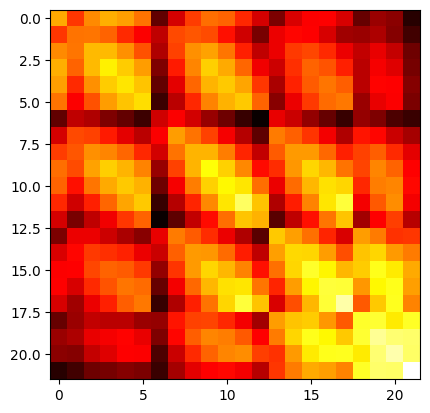

In [18]:
plt.imshow(x_cov, cmap="hot", interpolation="nearest")
plt.show()

In [19]:
lda, V = torch.linalg.eig(x_cov)
lda, V = lda.real, V.real
whitening_mat = V @ torch.sqrt(torch.inverse(torch.diag(lda))) @ V.T
# print(torch.allclose(whitening_mat, torch.sqrt(torch.inverse(x_cov))))
# whitening_mat = torch.inverse(torch.sqrt(x_cov))

whitening_mat.size()

torch.Size([22, 22])

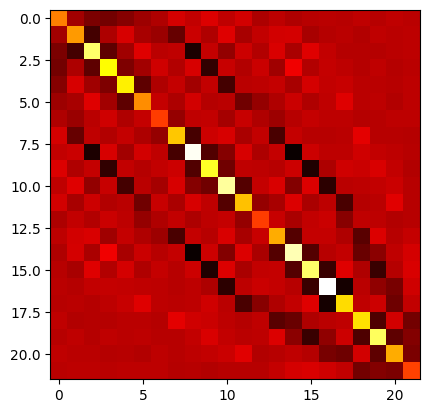

In [20]:
plt.imshow(whitening_mat, cmap="hot", interpolation="nearest")
plt.show()

In [21]:
whitened_signal = whitening_mat @ x_zero_centered
whitened_signal.size()

torch.Size([2592, 22, 1001])

In [22]:
x = whitened_signal
whitened_signal_cov = calc_cov(x)
whitened_signal_cov.shape

torch.Size([22, 22])

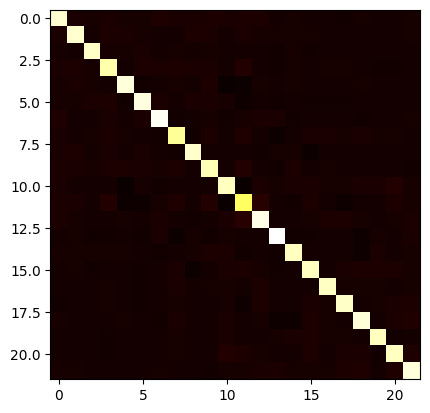

In [23]:
plt.imshow(whitened_signal_cov, cmap="hot", interpolation="nearest")
plt.show()

## Pytorch Dataset Transform Model

In [29]:
class Whitening:
    def __init__(self, data_loader, whitening_method="PCA"):
        self.ds = data_loader
        self.method = whitening_method

        self.W = self._generate_whitening_transformation(self.ds, self.method)

    def _generate_whitening_transformation(self, data_loader, whitening_method="PCA"):
        """extract whitening transformation from data

        Parameters
        ----------
        data_loader : torch.dataloader
            pytorch data loader
        whitening_method : str
            one of following values
            "PCA" for PCA whitening
            "ZCA for ZCA whitening

        Returns
        -------
        torch.Tensor
            whitening transformation matrix
        """
        # get data
        signal = []
        for sig, lbl in data_loader:
            signal.append(sig)
        signal = torch.vstack(signal)

        # zero center
        x = signal.squeeze()
        sig = x.permute(0, 2, 1)
        x = torch.mean(sig, axis=1)
        x_mean = torch.mean(x, axis=0)

        x = sig - x_mean
        x_zero_centered = x.permute(0, 2, 1)

        # Calculate whitening matrix
        x_cov = self._calc_cov(x_zero_centered)

        lda, V = torch.linalg.eig(x_cov)
        lda, V = lda.real, V.real
        if "PCA":
            whitening_mat = torch.sqrt(torch.inverse(torch.diag(lda))) @ V.T
        elif "ZCA":
            whitening_mat = V @ torch.sqrt(torch.inverse(torch.diag(lda))) @ V.T

        return whitening_mat

    def _calc_cov(self, EEG_data):
        cov = []
        for i in range(EEG_data.size()[0]):
            cov.append(
                EEG_data[i] @ EEG_data[i].T / torch.trace(EEG_data[i] @ EEG_data[i].T)
            )

        cov = torch.mean(torch.stack(cov), 0)

        return cov

    def __call__(self, data: Tensor, label):
        whitened_data = self.W @ data
        return whitened_data, label

In [31]:
transforms = [
    ToTensor(device="cuda"),
    DictToTensor(),
    ExpandDim(dim=2),
    ExpandDim(dim=2),
    LabelToDict(),
]
compose = Compose(transforms=transforms)

ds = BCI2aDataset(
    eeg_electrode_positions=electrod_positions,
    data_path=directory,
    transforms=compose,
    patients=[1],
)

In [32]:
train_dataset, val_dataset = ds.get_train_test_subsets()

train_dataloader = DataLoader(
    train_dataset,
    batch_size=1,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=1,
)

In [33]:
transforms = [
    ToTensor(device="cuda"),
    DictToTensor(),
    Whitening(train_dataloader, whitening_method="ZCA"),
    ExpandDim(dim=2),
    ExpandDim(dim=2),
    LabelToDict(),
]
compose = Compose(transforms=transforms)

ds_w = BCI2aDataset(
    eeg_electrode_positions=electrod_positions,
    data_path=directory,
    transforms=compose,
    patients=[1],
)

In [34]:
ds_w[0][0].size()

torch.Size([1, 22, 1, 1, 1001])

In [35]:
# train_dataset, _ = ds_w.get_train_test_subsets()

# train_dataloader = DataLoader(
#     train_dataset,
#     batch_size=1,
#     shuffle=False,
#     collate_fn=collate_fn,
#     num_workers=1,
# )

batch_size = 32
train_dataset, val_dataset = ds_w.get_train_test_subsets()

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=os.cpu_count(),
)


val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=collate_fn,
    num_workers=os.cpu_count(),
)

In [36]:
signal = []
for sig, lbl in tqdm(train_dataloader):
    signal.append(sig)
signal = torch.vstack(signal)
signal.size()

  0%|          | 0/9 [00:00<?, ?it/s]

torch.Size([288, 22, 1, 1, 1001])

In [37]:
whitened_signal_cov = calc_cov(signal.squeeze())
whitened_signal_cov.shape

torch.Size([22, 22])

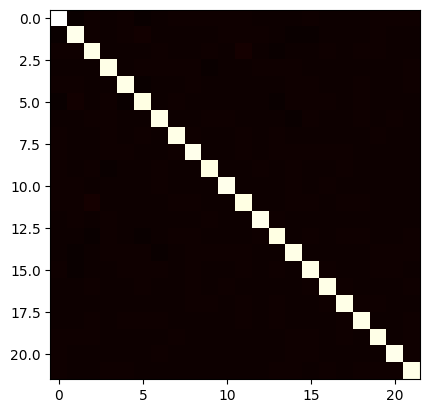

In [38]:
plt.imshow(whitened_signal_cov, cmap="hot", interpolation="nearest")
plt.show()

# Model

In [39]:
import torch
import numpy as np
import torch.nn as nn
from cspnn.csp_nn import CSP, CSPNN

import torch.optim as optim

import numpy as np
from sklearn.metrics import (
    roc_auc_score,
    precision_score,
    recall_score,
    accuracy_score,
    cohen_kappa_score,
)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm
import random

In [40]:
def evaluate(model, dl, params=["acc"]):
    model.eval()
    results = []
    predicted = []
    Y = []

    for batch in dl:
        inputs, labels = batch
        # inputs = torch.permute(
        #     torch.vstack(list(map(lambda a: a.unsqueeze(0), inputs.values()))),
        #     (1, 2, 3, 0),
        # )
        # wrap them in Variable
        # inputs, labels = inputs.cuda(0), labels.type(torch.LongTensor).cuda(0)

        pred = model(inputs.float().cuda(0))

        predicted.append(pred.cpu().detach())
        Y.append(labels["label"].type(torch.LongTensor).cpu())

    predicted = torch.cat(predicted, 0)
    Y = torch.cat(Y, 0)

    loss = cls_criterion(predicted, Y)

    predicted = predicted.numpy()
    Y = Y.numpy()

    for param in params:
        if param == "acc":
            results.append(accuracy_score(Y, np.argmax(predicted, axis=1)))
        if param == "auc":
            results.append(roc_auc_score(Y, predicted, multi_class="ovr"))
        if param == "kappa":
            results.append(cohen_kappa_score(Y, np.argmax(predicted, axis=1)))
        if param == "recall":
            results.append(
                recall_score(Y, np.argmax(predicted, axis=1), average="micro")
            )
        if param == "precision":
            results.append(
                precision_score(Y, np.argmax(predicted, axis=1), average="micro")
            )
        if param == "fmeasure":
            precision = precision_score(
                Y, np.argmax(predicted, axis=1), average="micro"
            )
            recall = recall_score(Y, np.argmax(predicted, axis=1), average="micro")
            results.append(2 * precision * recall / (precision + recall))

    results.append(loss)
    return results

In [41]:
class CSPNNCls(nn.Module):
    def __init__(
        self,
        num_channels: int,
        num_features: int = None,
        num_bands: int = None,
        num_windows: int = 1,
        num_labels: int = None,
        mode: str = "constant",
    ):
        super(CSPNNCls, self).__init__()
        self.num_channels = num_channels
        self.num_features = num_channels if num_features is None else num_features
        self.num_bands = num_bands
        self.num_windows = num_windows
        self.num_labels = num_labels
        self.mode = mode

        self.conv1 = CSPNN(
            num_channels=num_channels,
            num_features=num_features,
            num_bands=num_bands,
            num_windows=num_windows,
            num_labels=num_labels,
            mode=self.mode,
        )

        self.fc1 = nn.Linear(
            self.num_bands * self.num_windows * self.num_labels * self.num_features, 500
        )
        self.fc = nn.Linear(500, 4)

    def forward(self, x):
        csp = self.conv1(x)

        features = csp.reshape(
            (
                -1,
                self.num_bands * self.num_windows * self.num_labels * self.num_features,
            )
        )

        x = torch.tanh(self.fc1(features))

        x = F.softmax(self.fc(x), dim=1)
        if self.training:
            return x, csp
        return x


net = CSPNNCls(
    num_channels=22, num_features=22, num_bands=1, num_windows=1, num_labels=4
)
# .cuda(0)
cls_criterion = nn.CrossEntropyLoss()  # nn.BCELoss()
# reg_criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.00)
# lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(
#     optimizer, max_lr=0.1, steps_per_epoch=1, epochs=200
# )
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.1)

In [42]:
signals = torch.empty((10, 22, 1, 16, 769), dtype=torch.float32).random_(1, 50)
a, b = net(signals)
a.size(), b.size()

(torch.Size([10, 4]), torch.Size([10, 4, 22]))

In [43]:
net = net.cuda()

In [ ]:
history = {
    "train_loss": [],
    "test_loss": [],
    "train_acc": [],
    "test_acc": [],
    "lr": [],
    "train_kappa": [],
    "test_kappa": [],
}
batch_size = 32
alpha = 0.5

for epoch in range(1000):  # loop over the dataset multiple times
    print("\nEpoch ", epoch)

    net.train()
    running_loss = 0.0
    for i, batch in tqdm(enumerate(train_dataloader)):
        
        # print(i)
        inputs, labels = batch
        # inputs = torch.permute(
        #     torch.vstack(list(map(lambda a: a.unsqueeze(0), inputs.values()))),
        #     (1, 2, 3, 0),
        # )

        # wrap them in Variable
        # inputs, labels = inputs.cuda(0), labels.type(torch.LongTensor).cuda(0)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, csp_out = net(inputs.float().cuda(0))
        cls_loss = cls_criterion(
            outputs, labels["label"].type(torch.LongTensor).cuda(0)
        )
        # reg_loss = reg_criterion(csp, labels["csp"].cuda(0))
        # loss = cls_loss + (alpha * reg_loss)
        loss = cls_loss
        loss.backward()

        optimizer.step()

        running_loss += loss.item()

    history["lr"].append(optimizer.param_groups[0]["lr"])
    # print(optimizer.param_groups[0]["lr"])
    lr_scheduler.step()

    # Validation accuracy
    params = ["acc", "kappa", "auc", "fmeasure", "loss"]
    print(params)
    print("Training Loss ", running_loss / len(train_dataloader))
    tr = evaluate(net, train_dataloader, params)
    print("Train - ", tr)
    ev = evaluate(net, val_dataloader, params)
    print("Validation - ", ev)
    history["train_loss"].append(tr[-1])
    history["train_acc"].append(tr[0])
    history["train_kappa"].append(tr[1])

    history["test_loss"].append(ev[-1])
    history["test_acc"].append(ev[0])
    history["test_kappa"].append(ev[1])


Epoch  0


9it [00:01,  8.13it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.411381310886807


Train -  [0.4444444444444444, 0.2592592592592593, 0.8105388374485596, 0.4444444444444444, tensor(1.3855)]
Validation -  [0.3888888888888889, 0.18518518518518523, 0.7960551697530864, 0.3888888888888889, tensor(1.3871)]

Epoch  1


9it [00:00, 14.21it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.407748407787747


Train -  [0.25, 0.0, 0.834522890946502, 0.25, tensor(1.4251)]
Validation -  [0.25, 0.0, 0.8240419238683128, 0.25, tensor(1.4247)]

Epoch  2


9it [00:00, 11.63it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3844447003470526


Train -  [0.3159722222222222, 0.08796296296296291, 0.766798482510288, 0.3159722222222222, tensor(1.3884)]
Validation -  [0.25, 0.0, 0.7288773148148149, 0.25, tensor(1.3914)]

Epoch  3


9it [00:00, 13.88it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.385869820912679


Train -  [0.25, 0.0, 0.8589088220164609, 0.25, tensor(1.3708)]
Validation -  [0.25, 0.0, 0.84765625, 0.25, tensor(1.3717)]

Epoch  4


9it [00:00, 15.68it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3758362664116754


Train -  [0.2604166666666667, 0.01388888888888884, 0.8603395061728396, 0.2604166666666667, tensor(1.3620)]
Validation -  [0.2743055555555556, 0.03240740740740744, 0.8500996656378602, 0.2743055555555556, tensor(1.3623)]

Epoch  5


9it [00:00, 16.27it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.354338076379564


Train -  [0.3263888888888889, 0.10185185185185186, 0.8601144547325104, 0.3263888888888889, tensor(1.3457)]
Validation -  [0.3333333333333333, 0.11111111111111116, 0.848508230452675, 0.3333333333333333, tensor(1.3472)]

Epoch  6


9it [00:00, 15.18it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3400144047207303


Train -  [0.4895833333333333, 0.3194444444444444, 0.8844360853909464, 0.4895833333333333, tensor(1.3099)]
Validation -  [0.4895833333333333, 0.3194444444444444, 0.8631365740740741, 0.4895833333333333, tensor(1.3143)]

Epoch  7


9it [00:00, 14.15it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.30588518248664


Train -  [0.4618055555555556, 0.28240740740740744, 0.8867026748971194, 0.4618055555555556, tensor(1.2865)]
Validation -  [0.4791666666666667, 0.3055555555555556, 0.8763181584362141, 0.4791666666666667, tensor(1.2832)]

Epoch  8


9it [00:00, 12.06it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.300420535935296


Train -  [0.3784722222222222, 0.17129629629629628, 0.8447788065843621, 0.3784722222222222, tensor(1.3070)]
Validation -  [0.4270833333333333, 0.23611111111111116, 0.857638888888889, 0.4270833333333333, tensor(1.2953)]

Epoch  9


9it [00:00, 17.97it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2767364184061687


Train -  [0.4513888888888889, 0.2685185185185185, 0.8532182355967077, 0.4513888888888889, tensor(1.2644)]
Validation -  [0.4826388888888889, 0.31018518518518523, 0.8725726594650207, 0.4826388888888889, tensor(1.2506)]

Epoch  10


9it [00:00, 14.17it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2406666411293878


Train -  [0.5416666666666666, 0.38888888888888884, 0.8860918209876543, 0.5416666666666666, tensor(1.2316)]
Validation -  [0.5590277777777778, 0.4120370370370371, 0.8877957818930041, 0.5590277777777778, tensor(1.2308)]

Epoch  11


9it [00:00, 14.13it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2394804822074041


Train -  [0.5798611111111112, 0.43981481481481477, 0.9022472993827162, 0.5798611111111112, tensor(1.2018)]
Validation -  [0.5381944444444444, 0.3842592592592593, 0.8289930555555556, 0.5381944444444444, tensor(1.2411)]

Epoch  12


9it [00:00, 12.09it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2163725429111056


Train -  [0.5381944444444444, 0.3842592592592593, 0.8827481995884774, 0.5381944444444444, tensor(1.2000)]
Validation -  [0.4895833333333333, 0.3194444444444444, 0.795797968106996, 0.4895833333333333, tensor(1.2509)]

Epoch  13


9it [00:00, 12.09it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1993218262990315


Train -  [0.5347222222222222, 0.37962962962962965, 0.9028742283950618, 0.5347222222222222, tensor(1.1820)]
Validation -  [0.4618055555555556, 0.28240740740740744, 0.8298450360082305, 0.4618055555555556, tensor(1.2281)]

Epoch  14


9it [00:00, 14.45it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1925240092807345


Train -  [0.5972222222222222, 0.4629629629629629, 0.9154610339506173, 0.5972222222222222, tensor(1.1817)]
Validation -  [0.5486111111111112, 0.39814814814814814, 0.8766718106995884, 0.5486111111111112, tensor(1.1970)]

Epoch  15


9it [00:00, 17.62it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1922530730565388


Train -  [0.5902777777777778, 0.4537037037037037, 0.9261992026748971, 0.5902777777777778, tensor(1.1574)]
Validation -  [0.5, 0.33333333333333337, 0.8844039351851851, 0.5, tensor(1.1977)]

Epoch  16


9it [00:00, 15.22it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1544360054863825


Train -  [0.7291666666666666, 0.6388888888888888, 0.9231127829218108, 0.7291666666666665, tensor(1.1386)]
Validation -  [0.5625, 0.41666666666666663, 0.8598411779835391, 0.5625, tensor(1.1968)]

Epoch  17


9it [00:00, 14.96it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1390175157123141


Train -  [0.6909722222222222, 0.587962962962963, 0.9312628600823045, 0.6909722222222222, tensor(1.1132)]
Validation -  [0.59375, 0.45833333333333337, 0.8743409207818931, 0.59375, tensor(1.1690)]

Epoch  18


9it [00:00, 13.41it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1295799149407282


Train -  [0.7395833333333334, 0.6527777777777778, 0.938769933127572, 0.7395833333333334, tensor(1.0928)]
Validation -  [0.6354166666666666, 0.5138888888888888, 0.9000932355967077, 0.6354166666666666, tensor(1.1375)]

Epoch  19


9it [00:00, 16.78it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1135221322377522


Train -  [0.7743055555555556, 0.6990740740740741, 0.9435924639917695, 0.7743055555555556, tensor(1.0803)]
Validation -  [0.625, 0.5, 0.8963959619341564, 0.625, tensor(1.1435)]

Epoch  20


9it [00:00, 13.61it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0937655104531183


Train -  [0.7708333333333334, 0.6944444444444444, 0.9466628086419754, 0.7708333333333333, tensor(1.0607)]
Validation -  [0.6354166666666666, 0.5138888888888888, 0.9010095164609053, 0.6354166666666666, tensor(1.1269)]

Epoch  21


9it [00:00, 13.21it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0912859042485554


Train -  [0.6701388888888888, 0.5601851851851851, 0.9410847479423868, 0.6701388888888888, tensor(1.0885)]
Validation -  [0.5694444444444444, 0.42592592592592593, 0.8783918467078189, 0.5694444444444444, tensor(1.1543)]

Epoch  22


9it [00:00, 16.55it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0641802085770502


Train -  [0.7361111111111112, 0.6481481481481481, 0.9509870113168725, 0.7361111111111113, tensor(1.0489)]
Validation -  [0.6319444444444444, 0.5092592592592593, 0.913548096707819, 0.6319444444444444, tensor(1.1164)]

Epoch  23


9it [00:00, 12.25it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.054140607515971


Train -  [0.7638888888888888, 0.6851851851851851, 0.9541859567901234, 0.763888888888889, tensor(1.0445)]
Validation -  [0.5625, 0.41666666666666663, 0.9052051183127571, 0.5625, tensor(1.1436)]

Epoch  24


9it [00:00, 15.59it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0541682839393616


Train -  [0.6770833333333334, 0.5694444444444444, 0.9524980709876543, 0.6770833333333334, tensor(1.0765)]
Validation -  [0.5763888888888888, 0.43518518518518523, 0.9290605709876544, 0.5763888888888888, tensor(1.1345)]

Epoch  25


9it [00:00, 13.03it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0325765013694763


Train -  [0.75, 0.6666666666666667, 0.9488329475308642, 0.75, tensor(1.0350)]
Validation -  [0.6597222222222222, 0.5462962962962963, 0.9345904063786008, 0.6597222222222222, tensor(1.0863)]

Epoch  26


9it [00:00, 13.05it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0381931530104742


Train -  [0.8090277777777778, 0.7453703703703703, 0.9591370884773662, 0.8090277777777779, tensor(1.0082)]
Validation -  [0.59375, 0.45833333333333337, 0.909400720164609, 0.59375, tensor(1.1224)]

Epoch  27


9it [00:00, 10.15it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0108169383472867


Train -  [0.8298611111111112, 0.7731481481481481, 0.9611143261316872, 0.8298611111111112, tensor(0.9828)]
Validation -  [0.6527777777777778, 0.537037037037037, 0.9124549897119341, 0.6527777777777778, tensor(1.0931)]

Epoch  28


9it [00:00, 10.71it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9956691331333585


Train -  [0.7604166666666666, 0.6805555555555556, 0.9582047325102881, 0.7604166666666666, tensor(1.0170)]
Validation -  [0.6458333333333334, 0.5277777777777778, 0.9180330504115227, 0.6458333333333334, tensor(1.0774)]

Epoch  29


9it [00:00, 11.48it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9881113701396518


Train -  [0.8125, 0.75, 0.9618537808641976, 0.8125, tensor(0.9898)]
Validation -  [0.6979166666666666, 0.5972222222222222, 0.9090952932098766, 0.6979166666666666, tensor(1.0759)]

Epoch  30


9it [00:00, 14.18it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9860554999775357


Train -  [0.7777777777777778, 0.7037037037037037, 0.964891975308642, 0.7777777777777778, tensor(0.9863)]
Validation -  [0.6458333333333334, 0.5277777777777778, 0.9170363940329218, 0.6458333333333334, tensor(1.0915)]

Epoch  31


9it [00:00, 12.63it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9820774992307028


Train -  [0.7951388888888888, 0.7268518518518519, 0.9655832047325104, 0.7951388888888888, tensor(0.9854)]
Validation -  [0.6006944444444444, 0.46759259259259256, 0.9307002314814814, 0.6006944444444444, tensor(1.1026)]

Epoch  32


9it [00:00, 13.28it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9758958352936639


Train -  [0.84375, 0.7916666666666666, 0.9678658693415638, 0.84375, tensor(0.9546)]
Validation -  [0.6354166666666666, 0.5138888888888888, 0.9183224022633745, 0.6354166666666666, tensor(1.0865)]

Epoch  33


9it [00:00, 16.14it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.960159056716495


Train -  [0.7604166666666666, 0.6805555555555556, 0.9647151491769548, 0.7604166666666666, tensor(0.9842)]
Validation -  [0.78125, 0.7083333333333333, 0.9420974794238683, 0.78125, tensor(0.9983)]

Epoch  34


9it [00:00, 14.78it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9729059272342258


Train -  [0.8055555555555556, 0.7407407407407407, 0.9681069958847738, 0.8055555555555556, tensor(0.9641)]
Validation -  [0.6805555555555556, 0.5740740740740741, 0.9264885545267489, 0.6805555555555556, tensor(1.0407)]

Epoch  35


9it [00:00, 14.68it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9708072013325162


Train -  [0.7604166666666666, 0.6805555555555556, 0.9446373456790124, 0.7604166666666666, tensor(1.0026)]
Validation -  [0.5625, 0.41666666666666663, 0.8551472479423868, 0.5625, tensor(1.1639)]

Epoch  36


9it [00:00, 13.35it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9548022680812411


Train -  [0.8541666666666666, 0.8055555555555556, 0.9728813014403292, 0.8541666666666666, tensor(0.9245)]
Validation -  [0.6909722222222222, 0.587962962962963, 0.9307323816872428, 0.6909722222222222, tensor(1.0403)]

Epoch  37


9it [00:00, 11.88it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9853126472897


Train -  [0.8229166666666666, 0.7638888888888888, 0.9701324588477366, 0.8229166666666666, tensor(0.9548)]
Validation -  [0.6805555555555556, 0.5740740740740741, 0.9418081275720165, 0.6805555555555556, tensor(1.0567)]

Epoch  38


9it [00:00, 13.45it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9343275494045682


Train -  [0.8368055555555556, 0.7824074074074074, 0.9738618827160493, 0.8368055555555556, tensor(0.9337)]
Validation -  [0.7604166666666666, 0.6805555555555556, 0.938673482510288, 0.7604166666666666, tensor(1.0083)]

Epoch  39


9it [00:00, 14.72it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9453320966826545


Train -  [0.8125, 0.75, 0.9726401748971193, 0.8125, tensor(0.9548)]
Validation -  [0.71875, 0.625, 0.9346547067901235, 0.71875, tensor(1.0219)]

Epoch  40


9it [00:00, 12.12it/s]

Train -  [0.7986111111111112, 0.7314814814814814, 0.9718685699588476, 0.7986111111111112, tensor(0.9671)]
Validation -  [0.7326388888888888, 0.6435185185185186, 0.928272890946502, 0.7326388888888888, tensor(1.0251)]

Epoch  42


9it [00:00, 14.17it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.945268087916904


Train -  [0.8020833333333334, 0.7361111111111112, 0.9730902777777778, 0.8020833333333334, tensor(0.9502)]
Validation -  [0.7951388888888888, 0.7268518518518519, 0.9460198045267489, 0.7951388888888888, tensor(0.9758)]

Epoch  43


9it [00:00, 10.40it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9335204627778795


Train -  [0.8090277777777778, 0.7453703703703703, 0.9665959362139918, 0.8090277777777779, tensor(0.9500)]
Validation -  [0.7638888888888888, 0.6851851851851851, 0.9488168724279835, 0.763888888888889, tensor(0.9887)]

Epoch  44


9it [00:00, 13.58it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9356280366579691


Train -  [0.8784722222222222, 0.837962962962963, 0.9768036265432098, 0.8784722222222222, tensor(0.9118)]
Validation -  [0.7118055555555556, 0.6157407407407407, 0.9241898148148149, 0.7118055555555557, tensor(1.0330)]

Epoch  45


9it [00:00, 17.72it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9108480479982164


Train -  [0.875, 0.8333333333333334, 0.9755497685185185, 0.875, tensor(0.9042)]
Validation -  [0.6701388888888888, 0.5601851851851851, 0.9164416152263374, 0.6701388888888888, tensor(1.0580)]

Epoch  46


9it [00:00, 19.41it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9071146448453268


Train -  [0.8715277777777778, 0.8287037037037037, 0.97924704218107, 0.8715277777777778, tensor(0.8997)]
Validation -  [0.7395833333333334, 0.6527777777777778, 0.9429494598765432, 0.7395833333333334, tensor(1.0010)]

Epoch  47


9it [00:00, 16.45it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.896348324086931


Train -  [0.875, 0.8333333333333334, 0.9802758487654322, 0.875, tensor(0.8960)]
Validation -  [0.7430555555555556, 0.6574074074074074, 0.9382716049382716, 0.7430555555555556, tensor(1.0112)]

Epoch  48


9it [00:00, 15.15it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9101670384407043


Train -  [0.8819444444444444, 0.8425925925925926, 0.9806295010288066, 0.8819444444444444, tensor(0.8952)]
Validation -  [0.7152777777777778, 0.6203703703703703, 0.9377893518518519, 0.7152777777777778, tensor(1.0245)]

Epoch  49


9it [00:00, 15.90it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9037471214930216


Train -  [0.8784722222222222, 0.837962962962963, 0.9807902520576132, 0.8784722222222222, tensor(0.8945)]
Validation -  [0.7743055555555556, 0.6990740740740741, 0.9470968364197532, 0.7743055555555556, tensor(0.9983)]

Epoch  50


9it [00:00, 16.55it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9450822869936625


Train -  [0.8576388888888888, 0.8101851851851851, 0.9806134259259258, 0.8576388888888888, tensor(0.9081)]
Validation -  [0.6770833333333334, 0.5694444444444444, 0.9377893518518519, 0.6770833333333334, tensor(1.0506)]

Epoch  51


9it [00:00, 16.59it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9135768082406786


Train -  [0.75, 0.6666666666666667, 0.9757426697530864, 0.75, tensor(0.9813)]
Validation -  [0.5694444444444444, 0.42592592592592593, 0.9162808641975309, 0.5694444444444444, tensor(1.1500)]

Epoch  52


9it [00:00, 16.42it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9158274067772759


Train -  [0.8958333333333334, 0.8611111111111112, 0.9822370113168725, 0.8958333333333334, tensor(0.8840)]
Validation -  [0.7534722222222222, 0.6712962962962963, 0.9318897890946503, 0.7534722222222221, tensor(1.0054)]

Epoch  53


9it [00:00, 15.72it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9003471732139587


Train -  [0.8298611111111112, 0.7731481481481481, 0.9775109310699588, 0.8298611111111112, tensor(0.9153)]
Validation -  [0.8055555555555556, 0.7407407407407407, 0.9509548611111112, 0.8055555555555556, tensor(0.9555)]

Epoch  54


9it [00:00, 15.32it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9280224906073676


Train -  [0.78125, 0.7083333333333333, 0.9774627057613169, 0.78125, tensor(0.9671)]
Validation -  [0.6909722222222222, 0.587962962962963, 0.9491222993827162, 0.6909722222222222, tensor(1.0473)]

Epoch  55


9it [00:00, 15.09it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9158631033367581


Train -  [0.8958333333333334, 0.8611111111111112, 0.9838766718106997, 0.8958333333333334, tensor(0.8719)]
Validation -  [0.75, 0.6666666666666667, 0.9391557355967077, 0.75, tensor(0.9954)]

Epoch  56


9it [00:00, 16.18it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8770472738477919


Train -  [0.8993055555555556, 0.8657407407407407, 0.983249742798354, 0.8993055555555556, tensor(0.8790)]
Validation -  [0.71875, 0.625, 0.9390592849794239, 0.71875, tensor(1.0211)]

Epoch  57


9it [00:00, 14.56it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8789664970503913


Train -  [0.8472222222222222, 0.7962962962962963, 0.981642232510288, 0.8472222222222222, tensor(0.9102)]
Validation -  [0.7881944444444444, 0.7175925925925926, 0.948141718106996, 0.7881944444444445, tensor(0.9662)]

Epoch  58


9it [00:00, 17.77it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.878981696234809


Train -  [0.875, 0.8333333333333334, 0.9837159207818931, 0.875, tensor(0.8875)]
Validation -  [0.7881944444444444, 0.7175925925925926, 0.9393004115226338, 0.7881944444444445, tensor(0.9801)]

Epoch  59


9it [00:00, 23.51it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8961371978123983


Train -  [0.8506944444444444, 0.8009259259259259, 0.9834908693415637, 0.8506944444444444, tensor(0.8964)]
Validation -  [0.8020833333333334, 0.7361111111111112, 0.9456983024691359, 0.8020833333333334, tensor(0.9601)]

Epoch  60


9it [00:00, 21.97it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8957903186480204


Train -  [0.875, 0.8333333333333334, 0.9837802211934157, 0.875, tensor(0.8920)]
Validation -  [0.7534722222222222, 0.6712962962962963, 0.9326131687242798, 0.7534722222222221, tensor(0.9968)]

Epoch  61


9it [00:00, 15.02it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8876782788170708


Train -  [0.8993055555555556, 0.8657407407407407, 0.9846322016460906, 0.8993055555555556, tensor(0.8663)]
Validation -  [0.7708333333333334, 0.6944444444444444, 0.9496045524691359, 0.7708333333333333, tensor(0.9747)]

Epoch  62


9it [00:00, 16.70it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8647113376193576


Train -  [0.9027777777777778, 0.8703703703703703, 0.9861593364197531, 0.9027777777777778, tensor(0.8543)]
Validation -  [0.75, 0.6666666666666667, 0.9371945730452675, 0.75, tensor(1.0048)]

Epoch  63


9it [00:00, 16.68it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8611714839935303


Train -  [0.8923611111111112, 0.8564814814814815, 0.985693158436214, 0.8923611111111112, tensor(0.8733)]
Validation -  [0.7430555555555556, 0.6574074074074074, 0.9451035236625515, 0.7430555555555556, tensor(0.9947)]

Epoch  64


9it [00:00, 16.20it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.869731969303555


Train -  [0.9270833333333334, 0.9027777777777778, 0.9867862654320988, 0.9270833333333334, tensor(0.8480)]
Validation -  [0.7638888888888888, 0.6851851851851851, 0.943897890946502, 0.763888888888889, tensor(0.9848)]

Epoch  65


9it [00:00, 18.75it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8773134814368354


Train -  [0.90625, 0.875, 0.9847608024691359, 0.90625, tensor(0.8689)]
Validation -  [0.6944444444444444, 0.5925925925925926, 0.9242058899176955, 0.6944444444444444, tensor(1.0391)]

Epoch  66


9it [00:00, 16.42it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8652723762724135


Train -  [0.8923611111111112, 0.8564814814814815, 0.9826871141975309, 0.8923611111111112, tensor(0.8792)]
Validation -  [0.7708333333333334, 0.6944444444444444, 0.953125, 0.7708333333333333, tensor(0.9721)]

Epoch  67


9it [00:00, 16.24it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8663398755921258


Train -  [0.9131944444444444, 0.8842592592592593, 0.9873810442386832, 0.9131944444444444, tensor(0.8557)]
Validation -  [0.7326388888888888, 0.6435185185185186, 0.936230066872428, 0.7326388888888888, tensor(1.0179)]

Epoch  68


9it [00:00, 21.10it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8639080855581496


Train -  [0.8854166666666666, 0.8472222222222222, 0.9870273919753086, 0.8854166666666666, tensor(0.8820)]
Validation -  [0.6840277777777778, 0.5787037037037037, 0.9359407150205761, 0.6840277777777778, tensor(1.0567)]

Epoch  69


9it [00:00, 19.41it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8776654269960191


Train -  [0.9236111111111112, 0.8981481481481481, 0.9875257201646092, 0.9236111111111112, tensor(0.8469)]
Validation -  [0.7708333333333334, 0.6944444444444444, 0.9506815843621399, 0.7708333333333333, tensor(0.9770)]

Epoch  70


9it [00:00, 15.16it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8616254329681396


Train -  [0.9340277777777778, 0.912037037037037, 0.9886670524691358, 0.9340277777777778, tensor(0.8400)]
Validation -  [0.7743055555555556, 0.6990740740740741, 0.9496206275720164, 0.7743055555555556, tensor(0.9739)]

Epoch  71


9it [00:00, 15.24it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8551929725541009


Train -  [0.90625, 0.875, 0.9889564043209877, 0.90625, tensor(0.8740)]
Validation -  [0.7604166666666666, 0.6805555555555556, 0.9446212705761317, 0.7604166666666666, tensor(0.9895)]

Epoch  72


9it [00:00, 18.02it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8770690692795647


Train -  [0.8611111111111112, 0.8148148148148149, 0.9845196759259259, 0.8611111111111112, tensor(0.8853)]
Validation -  [0.7986111111111112, 0.7314814814814814, 0.9544913837448561, 0.7986111111111112, tensor(0.9504)]

Epoch  73


9it [00:00, 18.34it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8643534912003411


Train -  [0.9340277777777778, 0.912037037037037, 0.9891975308641976, 0.9340277777777778, tensor(0.8342)]
Validation -  [0.7743055555555556, 0.6990740740740741, 0.9481899434156379, 0.7743055555555556, tensor(0.9712)]

Epoch  74


9it [00:00, 14.11it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.854083432091607


Train -  [0.8958333333333334, 0.8611111111111112, 0.9892939814814815, 0.8958333333333334, tensor(0.8620)]
Validation -  [0.7118055555555556, 0.6157407407407407, 0.9413580246913581, 0.7118055555555557, tensor(1.0272)]

Epoch  75


9it [00:00, 19.63it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8667372133996751


Train -  [0.9409722222222222, 0.9212962962962963, 0.9901298868312758, 0.9409722222222222, tensor(0.8313)]
Validation -  [0.7569444444444444, 0.6759259259259259, 0.9416634516460906, 0.7569444444444444, tensor(0.9911)]

Epoch  76


9it [00:00, 18.07it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8386609156926473



9it [00:00, 16.12it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8294955823156569


Train -  [0.9375, 0.9166666666666666, 0.990451388888889, 0.9375, tensor(0.8258)]
Validation -  [0.78125, 0.7083333333333333, 0.9495724022633745, 0.78125, tensor(0.9597)]

Epoch  79


9it [00:00, 18.10it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8385350306828817


Train -  [0.9375, 0.9166666666666666, 0.9912069187242799, 0.9375, tensor(0.8271)]
Validation -  [0.7534722222222222, 0.6712962962962963, 0.9468717849794238, 0.7534722222222221, tensor(0.9879)]

Epoch  80


9it [00:00, 18.18it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8284912705421448


Train -  [0.9305555555555556, 0.9074074074074074, 0.9910461676954733, 0.9305555555555556, tensor(0.8392)]
Validation -  [0.7395833333333334, 0.6527777777777778, 0.9371784979423868, 0.7395833333333334, tensor(0.9982)]

Epoch  81


9it [00:00, 18.52it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.861150754822625


Train -  [0.90625, 0.875, 0.9873006687242799, 0.90625, tensor(0.8538)]
Validation -  [0.7881944444444444, 0.7175925925925926, 0.9554880401234569, 0.7881944444444445, tensor(0.9593)]

Epoch  82


9it [00:00, 21.04it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8571360641055636


Train -  [0.8888888888888888, 0.8518518518518519, 0.9900816615226338, 0.8888888888888888, tensor(0.8618)]
Validation -  [0.7777777777777778, 0.7037037037037037, 0.9531089248971194, 0.7777777777777778, tensor(0.9635)]

Epoch  83


9it [00:00, 15.10it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8871058821678162


Train -  [0.9513888888888888, 0.9351851851851852, 0.9914962705761317, 0.9513888888888888, tensor(0.8177)]
Validation -  [0.78125, 0.7083333333333333, 0.9492830504115227, 0.78125, tensor(0.9676)]

Epoch  84


9it [00:00, 16.30it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8375377058982849


Train -  [0.9340277777777778, 0.912037037037037, 0.9912069187242798, 0.9340277777777778, tensor(0.8346)]
Validation -  [0.7569444444444444, 0.6759259259259259, 0.9513567386831275, 0.7569444444444444, tensor(0.9784)]

Epoch  85


9it [00:00, 16.04it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8248084717326694


Train -  [0.9444444444444444, 0.9259259259259259, 0.9912069187242798, 0.9444444444444444, tensor(0.8307)]
Validation -  [0.7881944444444444, 0.7175925925925926, 0.9524819958847737, 0.7881944444444445, tensor(0.9554)]

Epoch  86


9it [00:00, 16.30it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8249898155530294


Train -  [0.9583333333333334, 0.9444444444444444, 0.9925733024691358, 0.9583333333333334, tensor(0.8140)]
Validation -  [0.7881944444444444, 0.7175925925925926, 0.9479327417695473, 0.7881944444444445, tensor(0.9596)]

Epoch  87


9it [00:00, 24.53it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8194523056348165


Train -  [0.9375, 0.9166666666666666, 0.991431970164609, 0.9375, tensor(0.8314)]
Validation -  [0.7638888888888888, 0.6851851851851851, 0.9534786522633745, 0.763888888888889, tensor(0.9658)]

Epoch  88


9it [00:00, 21.24it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8373605344030592


Train -  [0.9340277777777778, 0.912037037037037, 0.9909979423868313, 0.9340277777777778, tensor(0.8297)]
Validation -  [0.7638888888888888, 0.6851851851851851, 0.9545556841563786, 0.763888888888889, tensor(0.9566)]

Epoch  89


9it [00:00, 16.51it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8205193016264174


Train -  [0.9548611111111112, 0.9398148148148148, 0.9928144290123457, 0.9548611111111112, tensor(0.8110)]
Validation -  [0.7847222222222222, 0.712962962962963, 0.9437049897119342, 0.7847222222222222, tensor(0.9725)]

Epoch  90


9it [00:00, 16.43it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8156141042709351


Train -  [0.9236111111111112, 0.8981481481481481, 0.9919463734567902, 0.9236111111111112, tensor(0.8404)]
Validation -  [0.7256944444444444, 0.6342592592592593, 0.9425475823045267, 0.7256944444444444, tensor(1.0053)]

Epoch  91


9it [00:00, 19.61it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.83433864514033


Train -  [0.9340277777777778, 0.912037037037037, 0.9916891718106995, 0.9340277777777778, tensor(0.8293)]
Validation -  [0.7361111111111112, 0.6481481481481481, 0.9353620113168724, 0.7361111111111113, tensor(1.0098)]

Epoch  92


9it [00:00, 15.74it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8489307893647088


Train -  [0.9513888888888888, 0.9351851851851852, 0.9929269547325102, 0.9513888888888888, tensor(0.8084)]
Validation -  [0.7881944444444444, 0.7175925925925926, 0.9428369341563785, 0.7881944444444445, tensor(0.9715)]

Epoch  93


9it [00:00, 17.62it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8541743954022726


Train -  [0.8958333333333334, 0.8611111111111112, 0.9905639146090535, 0.8958333333333334, tensor(0.8521)]
Validation -  [0.7777777777777778, 0.7037037037037037, 0.9547807355967077, 0.7777777777777778, tensor(0.9633)]

Epoch  94


9it [00:00, 22.76it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8341364728079902


Train -  [0.8888888888888888, 0.8518518518518519, 0.9906925154320987, 0.8888888888888888, tensor(0.8764)]
Validation -  [0.7569444444444444, 0.6759259259259259, 0.9533982767489712, 0.7569444444444444, tensor(0.9951)]

Epoch  95


9it [00:00, 19.77it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.833865569697486


Train -  [0.9375, 0.9166666666666666, 0.9929108796296297, 0.9375, tensor(0.8257)]
Validation -  [0.7465277777777778, 0.662037037037037, 0.9404095936213992, 0.7465277777777777, tensor(0.9963)]

Epoch  96


9it [00:00, 16.88it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8438387049569024


Train -  [0.9444444444444444, 0.9259259259259259, 0.9921553497942386, 0.9444444444444444, tensor(0.8158)]
Validation -  [0.8090277777777778, 0.7453703703703703, 0.9516139403292181, 0.8090277777777779, tensor(0.9436)]

Epoch  97


9it [00:00, 19.40it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8185097310278151


Train -  [0.9375, 0.9166666666666666, 0.9924447016460904, 0.9375, tensor(0.8222)]
Validation -  [0.7743055555555556, 0.6990740740740741, 0.9485596707818931, 0.7743055555555556, tensor(0.9721)]

Epoch  98


9it [00:00, 20.68it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.823343363073137


Train -  [0.9270833333333334, 0.9027777777777778, 0.9911104681069959, 0.9270833333333334, tensor(0.8311)]
Validation -  [0.7534722222222222, 0.6712962962962963, 0.9323720421810701, 0.7534722222222221, tensor(0.9992)]

Epoch  99


9it [00:00, 20.54it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.828483071592119


Train -  [0.8923611111111112, 0.8564814814814815, 0.9915927211934157, 0.8923611111111112, tensor(0.8629)]
Validation -  [0.6909722222222222, 0.587962962962963, 0.9372347608024691, 0.6909722222222222, tensor(1.0384)]

Epoch  100


9it [00:00, 17.09it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8197119964493645


Train -  [0.9652777777777778, 0.9537037037037037, 0.9936021090534979, 0.9652777777777778, tensor(0.8031)]
Validation -  [0.7777777777777778, 0.7037037037037037, 0.947289737654321, 0.7777777777777778, tensor(0.9694)]

Epoch  101


9it [00:00, 15.86it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8149470090866089


Train -  [0.9305555555555556, 0.9074074074074074, 0.9928948045267489, 0.9305555555555556, tensor(0.8265)]
Validation -  [0.7847222222222222, 0.712962962962963, 0.9499903549382717, 0.7847222222222222, tensor(0.9566)]

Epoch  102


9it [00:00, 14.42it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8272156914075216


Train -  [0.9548611111111112, 0.9398148148148148, 0.9925733024691359, 0.9548611111111112, tensor(0.8123)]
Validation -  [0.7951388888888888, 0.7268518518518519, 0.953269675925926, 0.7951388888888888, tensor(0.9417)]

Epoch  103


9it [00:00, 18.04it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8401252230008444


Train -  [0.9652777777777778, 0.9537037037037037, 0.9934895833333334, 0.9652777777777778, tensor(0.8021)]
Validation -  [0.7847222222222222, 0.712962962962963, 0.9504083076131689, 0.7847222222222222, tensor(0.9507)]

Epoch  104


9it [00:00, 21.18it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.862099395857917


Train -  [0.8472222222222222, 0.7962962962962963, 0.9892136059670782, 0.8472222222222222, tensor(0.8949)]
Validation -  [0.6701388888888888, 0.5601851851851851, 0.9222206147119341, 0.6701388888888888, tensor(1.0609)]

Epoch  105


9it [00:00, 15.90it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8168164359198676


Train -  [0.9444444444444444, 0.9259259259259259, 0.9933609825102881, 0.9444444444444444, tensor(0.8138)]
Validation -  [0.75, 0.6666666666666667, 0.9403131430041152, 0.75, tensor(0.9902)]

Epoch  106


9it [00:00, 20.29it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8073407411575317


Train -  [0.9618055555555556, 0.9490740740740741, 0.9936824845679013, 0.9618055555555556, tensor(0.7992)]
Validation -  [0.7777777777777778, 0.7037037037037037, 0.9514692644032922, 0.7777777777777778, tensor(0.9649)]

Epoch  107


9it [00:00, 18.40it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8213135732544793


Train -  [0.96875, 0.9583333333333334, 0.9940200617283951, 0.96875, tensor(0.7977)]
Validation -  [0.7673611111111112, 0.6898148148148149, 0.9492509002057612, 0.7673611111111112, tensor(0.9694)]

Epoch  108


9it [00:00, 15.14it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8064136107762655


Train -  [0.96875, 0.9583333333333334, 0.9942772633744856, 0.96875, tensor(0.7927)]
Validation -  [0.7847222222222222, 0.712962962962963, 0.9478684413580246, 0.7847222222222222, tensor(0.9543)]

Epoch  109


9it [00:00, 14.97it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8143692347738478


Train -  [0.9652777777777778, 0.9537037037037037, 0.9937467849794239, 0.9652777777777778, tensor(0.8067)]
Validation -  [0.7986111111111112, 0.7314814814814814, 0.946068029835391, 0.7986111111111112, tensor(0.9570)]

Epoch  110


9it [00:00, 16.54it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8263052834404839


Train -  [0.9652777777777778, 0.9537037037037037, 0.9940522119341564, 0.9652777777777778, tensor(0.7981)]
Validation -  [0.7881944444444444, 0.7175925925925926, 0.947337962962963, 0.7881944444444445, tensor(0.9566)]

Epoch  111


9it [00:00, 19.19it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8022462394502428


Train -  [0.9513888888888888, 0.9351851851851852, 0.9944219393004115, 0.9513888888888888, tensor(0.8057)]
Validation -  [0.7638888888888888, 0.6851851851851851, 0.9479327417695472, 0.763888888888889, tensor(0.9849)]

Epoch  112


9it [00:00, 21.03it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.802899181842804


Train -  [0.9548611111111112, 0.9398148148148148, 0.9936985596707819, 0.9548611111111112, tensor(0.8096)]
Validation -  [0.7881944444444444, 0.7175925925925926, 0.9526909722222223, 0.7881944444444445, tensor(0.9506)]

Epoch  113


9it [00:00, 19.01it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8231044742796156


Train -  [0.8368055555555556, 0.7824074074074074, 0.9921553497942388, 0.8368055555555556, tensor(0.9159)]
Validation -  [0.7291666666666666, 0.6388888888888888, 0.9533982767489712, 0.7291666666666665, tensor(1.0153)]

Epoch  114


9it [00:00, 22.35it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8816308975219727


Train -  [0.9722222222222222, 0.962962962962963, 0.9941486625514404, 0.9722222222222222, tensor(0.7900)]
Validation -  [0.7743055555555556, 0.6990740740740741, 0.9527713477366255, 0.7743055555555556, tensor(0.9536)]

Epoch  115


9it [00:00, 15.54it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8599247932434082


Train -  [0.8090277777777778, 0.7453703703703703, 0.9923804012345679, 0.8090277777777779, tensor(0.9246)]
Validation -  [0.6388888888888888, 0.5185185185185186, 0.9418804655349795, 0.6388888888888888, tensor(1.0815)]

Epoch  116


9it [00:00, 16.42it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8417091170946757


Train -  [0.9166666666666666, 0.8888888888888888, 0.993971836419753, 0.9166666666666666, tensor(0.8319)]
Validation -  [0.7430555555555556, 0.6574074074074074, 0.9408918467078189, 0.7430555555555556, tensor(1.0107)]

Epoch  117


9it [00:00, 14.88it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8173513677385118


Train -  [0.9548611111111112, 0.9398148148148148, 0.9934895833333334, 0.9548611111111112, tensor(0.8073)]
Validation -  [0.7951388888888888, 0.7268518518518519, 0.9497170781893004, 0.7951388888888888, tensor(0.9441)]

Epoch  118


9it [00:00, 18.24it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.808195624086592


Train -  [0.9722222222222222, 0.962962962962963, 0.9943415637860082, 0.9722222222222222, tensor(0.7898)]
Validation -  [0.78125, 0.7083333333333333, 0.9491383744855967, 0.78125, tensor(0.9575)]

Epoch  119


9it [00:00, 16.54it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7997849914762709


Train -  [0.9583333333333334, 0.9444444444444444, 0.9937307098765432, 0.9583333333333334, tensor(0.7993)]
Validation -  [0.7673611111111112, 0.6898148148148149, 0.9537037037037037, 0.7673611111111112, tensor(0.9600)]

Epoch  120


9it [00:00, 22.46it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.798304193549686


Train -  [0.9548611111111112, 0.9398148148148148, 0.9940361368312758, 0.9548611111111112, tensor(0.8025)]
Validation -  [0.7777777777777778, 0.7037037037037037, 0.9513888888888888, 0.7777777777777778, tensor(0.9608)]

Epoch  121


9it [00:00, 23.64it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8025479647848341


Train -  [0.9583333333333334, 0.9444444444444444, 0.9942772633744856, 0.9583333333333334, tensor(0.7990)]
Validation -  [0.78125, 0.7083333333333333, 0.9462609310699588, 0.78125, tensor(0.9608)]

Epoch  122


9it [00:00, 15.74it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8171685073110793


Train -  [0.8888888888888888, 0.8518518518518519, 0.9924768518518519, 0.8888888888888888, tensor(0.8681)]
Validation -  [0.6701388888888888, 0.5601851851851851, 0.9307806069958848, 0.6701388888888888, tensor(1.0520)]

Epoch  123


9it [00:00, 14.19it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8613336682319641


Train -  [0.8993055555555556, 0.8657407407407407, 0.9932323816872427, 0.8993055555555556, tensor(0.8462)]
Validation -  [0.7118055555555556, 0.6157407407407407, 0.9389628343621399, 0.7118055555555557, tensor(1.0128)]

Epoch  124


9it [00:00, 14.72it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8827635182274712


Train -  [0.8472222222222222, 0.7962962962962963, 0.9868344907407408, 0.8472222222222222, tensor(0.8916)]
Validation -  [0.78125, 0.7083333333333333, 0.9542181069958847, 0.78125, tensor(0.9588)]

Epoch  125


9it [00:00, 16.46it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8436559372478061


Train -  [0.8715277777777778, 0.8287037037037037, 0.9935619212962963, 0.8715277777777778, tensor(0.8692)]
Validation -  [0.8020833333333334, 0.7361111111111112, 0.9431423611111112, 0.8020833333333334, tensor(0.9595)]

Epoch  126


9it [00:00, 19.56it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8708813587824503


Train -  [0.8923611111111112, 0.8564814814814815, 0.9923643261316872, 0.8923611111111112, tensor(0.8603)]
Validation -  [0.7430555555555556, 0.6574074074074074, 0.928514017489712, 0.7430555555555556, tensor(1.0039)]

Epoch  127


9it [00:00, 21.61it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8363225923644172


Train -  [0.8506944444444444, 0.8009259259259259, 0.9929108796296295, 0.8506944444444444, tensor(0.8865)]
Validation -  [0.7951388888888888, 0.7268518518518519, 0.9485596707818931, 0.7951388888888888, tensor(0.9497)]

Epoch  128


9it [00:00, 19.28it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8634957671165466


Train -  [0.9097222222222222, 0.8796296296296297, 0.9942290380658436, 0.9097222222222222, tensor(0.8360)]
Validation -  [0.7291666666666666, 0.6388888888888888, 0.9492348251028806, 0.7291666666666665, tensor(1.0119)]

Epoch  129


9it [00:00, 19.72it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8593528270721436


Train -  [0.8229166666666666, 0.7638888888888888, 0.988940329218107, 0.8229166666666666, tensor(0.9273)]
Validation -  [0.6979166666666666, 0.5972222222222222, 0.951806841563786, 0.6979166666666666, tensor(1.0455)]

Epoch  130


9it [00:00, 16.84it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8406733605596755


Train -  [0.9548611111111112, 0.9398148148148148, 0.9942451131687242, 0.9548611111111112, tensor(0.8025)]
Validation -  [0.7777777777777778, 0.7037037037037037, 0.9384966563786008, 0.7777777777777778, tensor(0.9731)]

Epoch  131


9it [00:00, 18.39it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7986699673864577


Train -  [0.9097222222222222, 0.8796296296296297, 0.9941486625514404, 0.9097222222222222, tensor(0.8358)]
Validation -  [0.78125, 0.7083333333333333, 0.9458590534979425, 0.78125, tensor(0.9600)]

Epoch  132


9it [00:00, 24.15it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8017831709649827


Train -  [0.96875, 0.9583333333333334, 0.9949363425925926, 0.96875, tensor(0.7908)]
Validation -  [0.78125, 0.7083333333333333, 0.9498778292181069, 0.78125, tensor(0.9616)]

Epoch  133


9it [00:00, 18.55it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7971477111180624


Train -  [0.9722222222222222, 0.962962962962963, 0.9947595164609053, 0.9722222222222222, tensor(0.7854)]
Validation -  [0.7881944444444444, 0.7175925925925926, 0.9517425411522634, 0.7881944444444445, tensor(0.9486)]

Epoch  134


9it [00:00, 15.11it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.794105953640408


Train -  [0.9756944444444444, 0.9675925925925926, 0.9950970936213992, 0.9756944444444444, tensor(0.7898)]
Validation -  [0.7673611111111112, 0.6898148148148149, 0.9463091563786008, 0.7673611111111112, tensor(0.9770)]

Epoch  135


9it [00:00, 13.41it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7873001827134026


Train -  [0.96875, 0.9583333333333334, 0.9948559670781894, 0.96875, tensor(0.7907)]
Validation -  [0.7743055555555556, 0.6990740740740741, 0.9474504886831276, 0.7743055555555556, tensor(0.9726)]

Epoch  136


9it [00:00, 15.67it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7969605326652527


Train -  [0.9305555555555556, 0.9074074074074074, 0.994212962962963, 0.9305555555555556, tensor(0.8203)]
Validation -  [0.7256944444444444, 0.6342592592592593, 0.9402809927983539, 0.7256944444444444, tensor(0.9967)]

Epoch  137


9it [00:00, 17.54it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8238020075692071


Train -  [0.9548611111111112, 0.9398148148148148, 0.9946630658436213, 0.9548611111111112, tensor(0.8004)]
Validation -  [0.7881944444444444, 0.7175925925925926, 0.9525462962962963, 0.7881944444444445, tensor(0.9606)]

Epoch  138


9it [00:00, 18.07it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7921104762289259


Train -  [0.9722222222222222, 0.962962962962963, 0.9952096193415638, 0.9722222222222222, tensor(0.7864)]
Validation -  [0.7569444444444444, 0.6759259259259259, 0.9520479681069959, 0.7569444444444444, tensor(0.9726)]

Epoch  139


9it [00:00, 20.49it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7856664194001092


Train -  [0.96875, 0.9583333333333334, 0.9952256944444444, 0.96875, tensor(0.7869)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.9436406893004116, 0.7916666666666666, tensor(0.9710)]

Epoch  140


9it [00:00, 18.24it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7912927799754672


Train -  [0.9652777777777778, 0.9537037037037037, 0.9953060699588477, 0.9652777777777778, tensor(0.7935)]
Validation -  [0.7708333333333334, 0.6944444444444444, 0.9471530992798354, 0.7708333333333333, tensor(0.9740)]

Epoch  141


9it [00:00, 16.29it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7845481634140015


Train -  [0.96875, 0.9583333333333334, 0.9950970936213992, 0.96875, tensor(0.7845)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.9428690843621399, 0.7916666666666666, tensor(0.9585)]

Epoch  142


9it [00:00, 15.90it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7942733830875821


Train -  [0.9479166666666666, 0.9305555555555556, 0.9947434413580247, 0.9479166666666666, tensor(0.8040)]
Validation -  [0.7986111111111112, 0.7314814814814814, 0.9521122685185186, 0.7986111111111112, tensor(0.9358)]

Epoch  143


9it [00:00, 15.99it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7896534403165182


Train -  [0.9756944444444444, 0.9675925925925926, 0.9955150462962963, 0.9756944444444444, tensor(0.7827)]
Validation -  [0.7743055555555556, 0.6990740740740741, 0.9440425668724279, 0.7743055555555556, tensor(0.9691)]

Epoch  144


9it [00:00, 17.29it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7816732194688585


Train -  [0.9722222222222222, 0.962962962962963, 0.9951292438271605, 0.9722222222222222, tensor(0.7811)]
Validation -  [0.7708333333333334, 0.6944444444444444, 0.9534304269547326, 0.7708333333333333, tensor(0.9573)]

Epoch  145


9it [00:00, 27.18it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7796487344635857


Train -  [0.9756944444444444, 0.9675925925925926, 0.9955954218106996, 0.9756944444444444, tensor(0.7776)]
Validation -  [0.7847222222222222, 0.712962962962963, 0.9457304526748971, 0.7847222222222222, tensor(0.9630)]

Epoch  146


9it [00:00, 19.57it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7816731267505221


Train -  [0.9756944444444444, 0.9675925925925926, 0.9955150462962963, 0.9756944444444444, tensor(0.7809)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.9501912937242799, 0.7916666666666666, tensor(0.9509)]

Epoch  147


9it [00:00, 17.75it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7793132464090983


Train -  [0.9756944444444444, 0.9675925925925926, 0.9956918724279836, 0.9756944444444444, tensor(0.7769)]
Validation -  [0.78125, 0.7083333333333333, 0.946485982510288, 0.78125, tensor(0.9648)]

Epoch  148


9it [00:00, 17.08it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7786034544308981


Train -  [0.9756944444444444, 0.9675925925925926, 0.9957883230452675, 0.9756944444444444, tensor(0.7760)]
Validation -  [0.7881944444444444, 0.7175925925925926, 0.9474183384773663, 0.7881944444444445, tensor(0.9613)]

Epoch  149


9it [00:00, 19.19it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7802117400699191


Train -  [0.9583333333333334, 0.9444444444444444, 0.9951453189300412, 0.9583333333333334, tensor(0.7941)]
Validation -  [0.8159722222222222, 0.7546296296296297, 0.9501350308641976, 0.8159722222222222, tensor(0.9388)]

Epoch  150


9it [00:00, 16.64it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7809225983089871


Train -  [0.9791666666666666, 0.9722222222222222, 0.9958204732510287, 0.9791666666666666, tensor(0.7754)]
Validation -  [0.7708333333333334, 0.6944444444444444, 0.9470807613168724, 0.7708333333333333, tensor(0.9648)]

Epoch  151


9it [00:00, 20.85it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7794563306702508


Train -  [0.9756944444444444, 0.9675925925925926, 0.9959490740740742, 0.9756944444444444, tensor(0.7765)]
Validation -  [0.7743055555555556, 0.6990740740740741, 0.9503600823045267, 0.7743055555555556, tensor(0.9612)]

Epoch  152


9it [00:00, 23.53it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7778541247049967


Train -  [0.9756944444444444, 0.9675925925925926, 0.9961741255144034, 0.9756944444444444, tensor(0.7755)]
Validation -  [0.7777777777777778, 0.7037037037037037, 0.9488007973251029, 0.7777777777777778, tensor(0.9657)]

Epoch  153


9it [00:00, 22.11it/s]


['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7802785038948059
Train -  [0.9791666666666666, 0.9722222222222222, 0.9958526234567902, 0.9791666666666666, tensor(0.7727)]
Validation -  [0.7743055555555556, 0.6990740740740741, 0.9491544495884774, 0.7743055555555556, tensor(0.9599)]

Epoch  154


9it [00:00, 17.23it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7773071858617995


Train -  [0.9652777777777778, 0.9537037037037037, 0.9955954218106995, 0.9652777777777778, tensor(0.7901)]
Validation -  [0.7743055555555556, 0.6990740740740741, 0.9520961934156378, 0.7743055555555556, tensor(0.9663)]

Epoch  155


9it [00:00, 21.03it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7828099793857999


Train -  [0.9444444444444444, 0.9259259259259259, 0.9951774691358024, 0.9444444444444444, tensor(0.8000)]
Validation -  [0.75, 0.6666666666666667, 0.9420894418724279, 0.75, tensor(0.9721)]

Epoch  156


9it [00:00, 22.88it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.781683537695143


Train -  [0.9513888888888888, 0.9351851851851852, 0.995338220164609, 0.9513888888888888, tensor(0.7942)]
Validation -  [0.7673611111111112, 0.6898148148148149, 0.94262795781893, 0.7673611111111112, tensor(0.9696)]

Epoch  157


9it [00:00, 19.28it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7867371042569479


Train -  [0.9722222222222222, 0.962962962962963, 0.9956114969135803, 0.9722222222222222, tensor(0.7851)]
Validation -  [0.7881944444444444, 0.7175925925925926, 0.9472334747942387, 0.7881944444444445, tensor(0.9533)]

Epoch  158


9it [00:00, 18.52it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7891054219669766


Train -  [0.9479166666666666, 0.9305555555555556, 0.9954507458847737, 0.9479166666666666, tensor(0.7977)]
Validation -  [0.7604166666666666, 0.6805555555555556, 0.9431102109053497, 0.7604166666666666, tensor(0.9770)]

Epoch  159


9it [00:00, 22.93it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8034485512309604


Train -  [0.9791666666666666, 0.9722222222222222, 0.9956597222222223, 0.9791666666666666, tensor(0.7775)]
Validation -  [0.7847222222222222, 0.712962962962963, 0.942459169238683, 0.7847222222222222, tensor(0.9605)]

Epoch  160


9it [00:00, 21.75it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7815027832984924


Train -  [0.9652777777777778, 0.9537037037037037, 0.9954507458847737, 0.9652777777777778, tensor(0.7902)]
Validation -  [0.7986111111111112, 0.7314814814814814, 0.9461885931069958, 0.7986111111111112, tensor(0.9484)]

Epoch  161


9it [00:00, 22.03it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7801735202471415


Train -  [0.9756944444444444, 0.9675925925925926, 0.9956275720164609, 0.9756944444444444, tensor(0.7856)]
Validation -  [0.7986111111111112, 0.7314814814814814, 0.944605195473251, 0.7986111111111112, tensor(0.9523)]

Epoch  162


9it [00:00, 18.61it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7825962569978502


Train -  [0.9513888888888888, 0.9351851851851852, 0.9954507458847737, 0.9513888888888888, tensor(0.8075)]
Validation -  [0.7638888888888888, 0.6851851851851851, 0.9449106224279835, 0.763888888888889, tensor(0.9656)]

Epoch  163


9it [00:00, 21.80it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7835681041081747


Train -  [0.9652777777777778, 0.9537037037037037, 0.995482896090535, 0.9652777777777778, tensor(0.7921)]
Validation -  [0.7847222222222222, 0.712962962962963, 0.9475469393004116, 0.7847222222222222, tensor(0.9554)]

Epoch  164


9it [00:00, 15.38it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7854679955376519


Train -  [0.9513888888888888, 0.9351851851851852, 0.9954507458847737, 0.9513888888888888, tensor(0.8085)]
Validation -  [0.8020833333333334, 0.7361111111111112, 0.9502073688271604, 0.8020833333333334, tensor(0.9424)]

Epoch  165


9it [00:00, 14.37it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7913890547222562


Train -  [0.96875, 0.9583333333333334, 0.9959329989711934, 0.96875, tensor(0.7910)]
Validation -  [0.7534722222222222, 0.6712962962962963, 0.9417599022633745, 0.7534722222222221, tensor(0.9844)]

Epoch  166


9it [00:00, 15.27it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7801853617032369


Train -  [0.9618055555555556, 0.9490740740740741, 0.9957079475308641, 0.9618055555555556, tensor(0.7923)]
Validation -  [0.75, 0.6666666666666667, 0.9431664737654321, 0.75, tensor(0.9801)]

Epoch  167


9it [00:00, 19.16it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7832229402330186


Train -  [0.9791666666666666, 0.9722222222222222, 0.9958043981481481, 0.9791666666666666, tensor(0.7725)]
Validation -  [0.7847222222222222, 0.712962962962963, 0.944211355452675, 0.7847222222222222, tensor(0.9573)]

Epoch  168


9it [00:00, 16.78it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7830888231595358


Train -  [0.9791666666666666, 0.9722222222222222, 0.9956114969135803, 0.9791666666666666, tensor(0.7701)]
Validation -  [0.7847222222222222, 0.712962962962963, 0.9502475565843622, 0.7847222222222222, tensor(0.9536)]

Epoch  169


9it [00:00, 15.58it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7700412273406982


Train -  [0.9826388888888888, 0.9768518518518519, 0.9958204732510288, 0.9826388888888888, tensor(0.7675)]
Validation -  [0.7777777777777778, 0.7037037037037037, 0.9476112397119341, 0.7777777777777778, tensor(0.9592)]

Epoch  170


9it [00:00, 14.56it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7690684331787957


Train -  [0.9756944444444444, 0.9675925925925926, 0.9950970936213992, 0.9756944444444444, tensor(0.7921)]
Validation -  [0.7847222222222222, 0.712962962962963, 0.9426842206790123, 0.7847222222222222, tensor(0.9577)]

Epoch  171


9it [00:00, 14.61it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7813936935530769


Train -  [0.9791666666666666, 0.9722222222222222, 0.9955873842592593, 0.9791666666666666, tensor(0.7688)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.9494598765432098, 0.7916666666666666, tensor(0.9481)]

Epoch  172


9it [00:00, 15.88it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.787664618757036


Train -  [0.9513888888888888, 0.9351851851851852, 0.9954025205761317, 0.9513888888888888, tensor(0.8045)]
Validation -  [0.8125, 0.75, 0.9473218878600823, 0.8125, tensor(0.9422)]

Epoch  173


9it [00:00, 18.76it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7918195989396837


Train -  [0.9513888888888888, 0.9351851851851852, 0.9950810185185185, 0.9513888888888888, tensor(0.8132)]
Validation -  [0.78125, 0.7083333333333333, 0.944114904835391, 0.78125, tensor(0.9573)]

Epoch  174


9it [00:00, 19.44it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7800793515311347


Train -  [0.9756944444444444, 0.9675925925925926, 0.995482896090535, 0.9756944444444444, tensor(0.7834)]
Validation -  [0.7847222222222222, 0.712962962962963, 0.9435522762345678, 0.7847222222222222, tensor(0.9539)]

Epoch  175


9it [00:00, 16.94it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7762206064330207


Train -  [0.9791666666666666, 0.9722222222222222, 0.9958043981481481, 0.9791666666666666, tensor(0.7666)]
Validation -  [0.7743055555555556, 0.6990740740740741, 0.9473058127572017, 0.7743055555555556, tensor(0.9544)]

Epoch  176


9it [00:00, 18.87it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7806642916467454


Train -  [0.9861111111111112, 0.9814814814814815, 0.996045524691358, 0.9861111111111112, tensor(0.7663)]
Validation -  [0.7638888888888888, 0.6851851851851851, 0.9506494341563786, 0.763888888888889, tensor(0.9559)]

Epoch  177


9it [00:00, 19.48it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7699732383092245


Train -  [0.9826388888888888, 0.9768518518518519, 0.9956597222222222, 0.9826388888888888, tensor(0.7680)]
Validation -  [0.78125, 0.7083333333333333, 0.9470325360082305, 0.78125, tensor(0.9590)]

Epoch  178


9it [00:00, 18.79it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7679645948939853


Train -  [0.9826388888888888, 0.9768518518518519, 0.9961741255144034, 0.9826388888888888, tensor(0.7743)]
Validation -  [0.7673611111111112, 0.6898148148148149, 0.9502314814814815, 0.7673611111111112, tensor(0.9777)]

Epoch  179


9it [00:00, 18.85it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7698664598994784


Train -  [0.9861111111111112, 0.9814814814814815, 0.996141975308642, 0.9861111111111112, tensor(0.7669)]
Validation -  [0.7708333333333334, 0.6944444444444444, 0.9498617541152263, 0.7708333333333333, tensor(0.9690)]

Epoch  180


9it [00:00, 20.93it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7683260771963332


Train -  [0.9826388888888888, 0.9768518518518519, 0.996045524691358, 0.9826388888888888, tensor(0.7676)]
Validation -  [0.7743055555555556, 0.6990740740740741, 0.9441550925925926, 0.7743055555555556, tensor(0.9699)]

Epoch  181


9it [00:00, 14.82it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7687403824594286


Train -  [0.9826388888888888, 0.9768518518518519, 0.9958365483539094, 0.9826388888888888, tensor(0.7671)]
Validation -  [0.7673611111111112, 0.6898148148148149, 0.951340663580247, 0.7673611111111112, tensor(0.9598)]

Epoch  182


9it [00:00, 14.59it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7655066516664293


Train -  [0.9861111111111112, 0.9814814814814815, 0.9959169238683128, 0.9861111111111112, tensor(0.7632)]
Validation -  [0.7638888888888888, 0.6851851851851851, 0.9459876543209876, 0.763888888888889, tensor(0.9631)]

Epoch  183


9it [00:00, 17.03it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7635915146933662


Train -  [0.9861111111111112, 0.9814814814814815, 0.9958526234567902, 0.9861111111111112, tensor(0.7627)]
Validation -  [0.7673611111111112, 0.6898148148148149, 0.9496367026748972, 0.7673611111111112, tensor(0.9555)]

Epoch  184


9it [00:00, 20.04it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7635848654641045


Train -  [0.9861111111111112, 0.9814814814814815, 0.99609375, 0.9861111111111112, tensor(0.7631)]
Validation -  [0.7708333333333334, 0.6944444444444444, 0.9466467335390947, 0.7708333333333333, tensor(0.9660)]

Epoch  185


9it [00:00, 19.64it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7655535141626993


Train -  [0.9861111111111112, 0.9814814814814815, 0.9962062757201646, 0.9861111111111112, tensor(0.7633)]
Validation -  [0.7638888888888888, 0.6851851851851851, 0.9480291923868313, 0.763888888888889, tensor(0.9644)]

Epoch  186


9it [00:00, 24.97it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7651824884944491


Train -  [0.9861111111111112, 0.9814814814814815, 0.995482896090535, 0.9861111111111112, tensor(0.7719)]
Validation -  [0.7777777777777778, 0.7037037037037037, 0.9491544495884774, 0.7777777777777778, tensor(0.9557)]

Epoch  187


9it [00:00, 25.07it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7683670851919386


Train -  [0.9861111111111112, 0.9814814814814815, 0.9956597222222222, 0.9861111111111112, tensor(0.7655)]
Validation -  [0.7777777777777778, 0.7037037037037037, 0.9479166666666667, 0.7777777777777778, tensor(0.9651)]

Epoch  188


9it [00:00, 17.50it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7648255758815341


Train -  [0.9861111111111112, 0.9814814814814815, 0.9959008487654322, 0.9861111111111112, tensor(0.7639)]
Validation -  [0.7743055555555556, 0.6990740740740741, 0.9493955761316872, 0.7743055555555556, tensor(0.9516)]

Epoch  189


9it [00:00, 18.59it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7653792632950677


Train -  [0.9861111111111112, 0.9814814814814815, 0.9959329989711935, 0.9861111111111112, tensor(0.7646)]
Validation -  [0.7638888888888888, 0.6851851851851851, 0.9413901748971194, 0.763888888888889, tensor(0.9702)]

Epoch  190


9it [00:00, 20.86it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7711009383201599


Train -  [0.9826388888888888, 0.9768518518518519, 0.9958847736625515, 0.9826388888888888, tensor(0.7684)]
Validation -  [0.7708333333333334, 0.6944444444444444, 0.9520801183127572, 0.7708333333333333, tensor(0.9524)]

Epoch  191


9it [00:00, 13.73it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7656557957331339


Train -  [0.9861111111111112, 0.9814814814814815, 0.9962866512345678, 0.9861111111111112, tensor(0.7640)]
Validation -  [0.7673611111111112, 0.6898148148148149, 0.9471129115226338, 0.7673611111111112, tensor(0.9708)]

Epoch  192


9it [00:00, 15.59it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7642304963535733


Train -  [0.9861111111111112, 0.9814814814814815, 0.9956918724279836, 0.9861111111111112, tensor(0.7640)]
Validation -  [0.7847222222222222, 0.712962962962963, 0.947386188271605, 0.7847222222222222, tensor(0.9613)]

Epoch  193


9it [00:00, 14.48it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7621287239922417


Train -  [0.9861111111111112, 0.9814814814814815, 0.9960133744855967, 0.9861111111111112, tensor(0.7618)]
Validation -  [0.7708333333333334, 0.6944444444444444, 0.9493795010288065, 0.7708333333333333, tensor(0.9527)]

Epoch  194


9it [00:00, 17.11it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.765884108013577


Train -  [0.9861111111111112, 0.9814814814814815, 0.9965760030864197, 0.9861111111111112, tensor(0.7666)]
Validation -  [0.7569444444444444, 0.6759259259259259, 0.94555362654321, 0.7569444444444444, tensor(0.9769)]

Epoch  195


9it [00:00, 19.84it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7640341189172533


Train -  [0.9861111111111112, 0.9814814814814815, 0.9959812242798354, 0.9861111111111112, tensor(0.7606)]
Validation -  [0.7708333333333334, 0.6944444444444444, 0.9496688528806584, 0.7708333333333333, tensor(0.9542)]

Epoch  196


9it [00:00, 17.13it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7626568078994751


Train -  [0.9861111111111112, 0.9814814814814815, 0.9958365483539094, 0.9861111111111112, tensor(0.7599)]
Validation -  [0.7743055555555556, 0.6990740740740741, 0.9487364969135803, 0.7743055555555556, tensor(0.9549)]

Epoch  197


9it [00:00, 15.70it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7631533145904541


Train -  [0.9861111111111112, 0.9814814814814815, 0.9959169238683128, 0.9861111111111112, tensor(0.7611)]
Validation -  [0.7708333333333334, 0.6944444444444444, 0.9490419238683128, 0.7708333333333333, tensor(0.9634)]

Epoch  198


9it [00:00, 20.33it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7602885497940911


Train -  [0.9895833333333334, 0.9861111111111112, 0.9958847736625515, 0.9895833333333334, tensor(0.7598)]
Validation -  [0.7777777777777778, 0.7037037037037037, 0.9487525720164609, 0.7777777777777778, tensor(0.9578)]

Epoch  199


9it [00:00, 13.31it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7617477509710524


Train -  [0.9861111111111112, 0.9814814814814815, 0.9959329989711935, 0.9861111111111112, tensor(0.7592)]
Validation -  [0.78125, 0.7083333333333333, 0.9481979809670782, 0.78125, tensor(0.9535)]

Epoch  200


9it [00:00, 18.05it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7597102920214335


Train -  [0.9895833333333334, 0.9861111111111112, 0.9958043981481481, 0.9895833333333334, tensor(0.7591)]
Validation -  [0.7881944444444444, 0.7175925925925926, 0.948439107510288, 0.7881944444444445, tensor(0.9500)]

Epoch  201


9it [00:00, 14.45it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7591906388600668


Train -  [0.9895833333333334, 0.9861111111111112, 0.9958526234567902, 0.9895833333333334, tensor(0.7588)]
Validation -  [0.7708333333333334, 0.6944444444444444, 0.9488329475308642, 0.7708333333333333, tensor(0.9560)]

Epoch  202


9it [00:00, 14.71it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7588810722033182


Train -  [0.9895833333333334, 0.9861111111111112, 0.9958365483539094, 0.9895833333333334, tensor(0.7587)]
Validation -  [0.7777777777777778, 0.7037037037037037, 0.948559670781893, 0.7777777777777778, tensor(0.9550)]

Epoch  203


9it [00:00, 16.09it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7587833536995782


Train -  [0.9895833333333334, 0.9861111111111112, 0.9959008487654322, 0.9895833333333334, tensor(0.7586)]
Validation -  [0.7777777777777778, 0.7037037037037037, 0.948366769547325, 0.7777777777777778, tensor(0.9542)]

Epoch  204


9it [00:00, 20.47it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7588370773527358


Train -  [0.9895833333333334, 0.9861111111111112, 0.9959008487654322, 0.9895833333333334, tensor(0.7586)]
Validation -  [0.7743055555555556, 0.6990740740740741, 0.9481899434156378, 0.7743055555555556, tensor(0.9554)]

Epoch  205


9it [00:00, 21.27it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.758956684006585


Train -  [0.9895833333333334, 0.9861111111111112, 0.9958365483539094, 0.9895833333333334, tensor(0.7587)]
Validation -  [0.78125, 0.7083333333333333, 0.9483989197530864, 0.78125, tensor(0.9527)]

Epoch  206


9it [00:00, 20.12it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7586824496587118


Train -  [0.9895833333333334, 0.9861111111111112, 0.9958847736625515, 0.9895833333333334, tensor(0.7585)]
Validation -  [0.7777777777777778, 0.7037037037037037, 0.9486078960905349, 0.7777777777777778, tensor(0.9544)]

Epoch  207


9it [00:00, 17.22it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7585513459311591


Train -  [0.9895833333333334, 0.9861111111111112, 0.9959008487654322, 0.9895833333333334, tensor(0.7585)]
Validation -  [0.7777777777777778, 0.7037037037037037, 0.9483346193415637, 0.7777777777777778, tensor(0.9545)]

Epoch  208


9it [00:00, 22.19it/s]


['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7587509552637736
Train -  [0.9895833333333334, 0.9861111111111112, 0.9958526234567902, 0.9895833333333334, tensor(0.7584)]
Validation -  [0.7777777777777778, 0.7037037037037037, 0.9484953703703702, 0.7777777777777778, tensor(0.9550)]

Epoch  209


9it [00:00, 19.57it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7584643297725253


Train -  [0.9895833333333334, 0.9861111111111112, 0.9959008487654322, 0.9895833333333334, tensor(0.7584)]
Validation -  [0.7743055555555556, 0.6990740740740741, 0.9481899434156379, 0.7743055555555556, tensor(0.9549)]

Epoch  210


9it [00:00, 25.53it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7585325704680549


Train -  [0.9895833333333334, 0.9861111111111112, 0.9959008487654322, 0.9895833333333334, tensor(0.7584)]
Validation -  [0.7743055555555556, 0.6990740740740741, 0.9483346193415638, 0.7743055555555556, tensor(0.9555)]

Epoch  211


9it [00:00, 20.53it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7586268650160896


Train -  [0.9895833333333334, 0.9861111111111112, 0.9958526234567902, 0.9895833333333334, tensor(0.7584)]
Validation -  [0.7777777777777778, 0.7037037037037037, 0.9484792952674896, 0.7777777777777778, tensor(0.9540)]

Epoch  212


9it [00:00, 27.16it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7583724723921882


Train -  [0.9895833333333334, 0.9861111111111112, 0.9959008487654322, 0.9895833333333334, tensor(0.7583)]
Validation -  [0.7777777777777778, 0.7037037037037037, 0.9484551826131687, 0.7777777777777778, tensor(0.9542)]

Epoch  213


9it [00:00, 19.86it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7583843734529283


Train -  [0.9895833333333334, 0.9861111111111112, 0.9959008487654322, 0.9895833333333334, tensor(0.7583)]
Validation -  [0.7777777777777778, 0.7037037037037037, 0.9482060185185186, 0.7777777777777778, tensor(0.9544)]

Epoch  214


9it [00:00, 19.41it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7585594654083252


Train -  [0.9895833333333334, 0.9861111111111112, 0.9959329989711934, 0.9895833333333334, tensor(0.7583)]
Validation -  [0.7743055555555556, 0.6990740740740741, 0.9486561213991769, 0.7743055555555556, tensor(0.9571)]

Epoch  215


9it [00:00, 19.10it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.758312894238366


Train -  [0.9895833333333334, 0.9861111111111112, 0.9958847736625515, 0.9895833333333334, tensor(0.7582)]
Validation -  [0.7777777777777778, 0.7037037037037037, 0.9483667695473251, 0.7777777777777778, tensor(0.9537)]

Epoch  216


9it [00:00, 17.65it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7583109074168735


Train -  [0.9895833333333334, 0.9861111111111112, 0.9958526234567902, 0.9895833333333334, tensor(0.7582)]
Validation -  [0.7777777777777778, 0.7037037037037037, 0.9484792952674898, 0.7777777777777778, tensor(0.9532)]

Epoch  217


In [ ]:
idx = np.argmax(history["test_acc"])
{k: history[k][idx] for k in history.keys()}

{'train_loss': tensor(0.7941),
 'test_loss': tensor(0.9388),
 'train_acc': 0.9583333333333334,
 'test_acc': 0.8159722222222222,
 'lr': 0.001,
 'train_kappa': 0.9444444444444444,
 'test_kappa': 0.7546296296296297}

In [46]:
import matplotlib.pyplot as plt

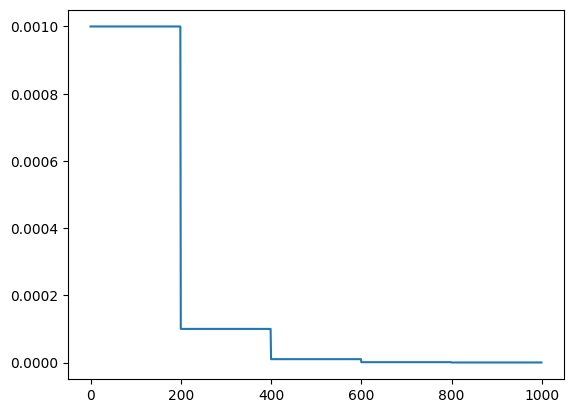

In [47]:
plt.plot([i for i in range(len(history["lr"]))], history["lr"])

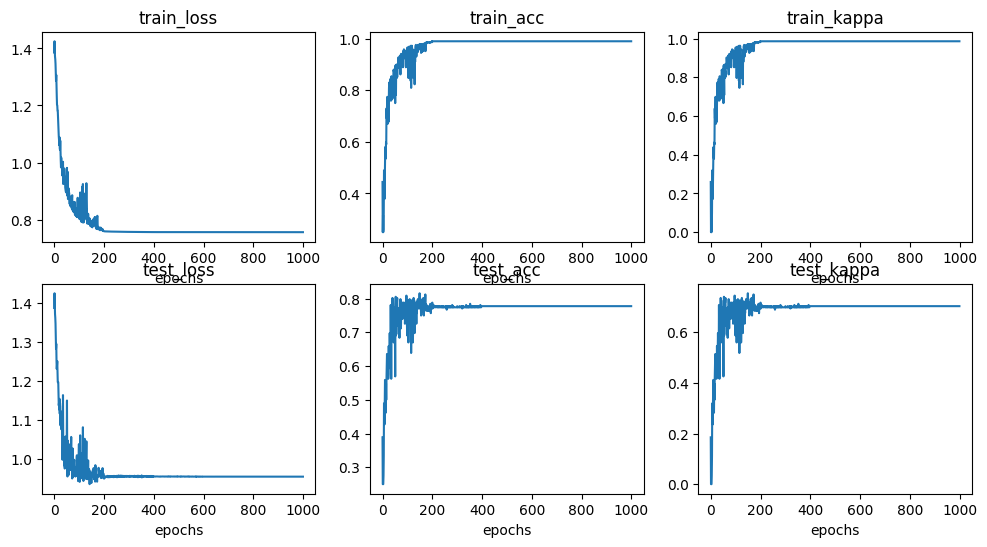

In [48]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6))

for i, title in enumerate(
    [
        "train_loss",
        "train_acc",
        "train_kappa",
        "test_loss",
        "test_acc",
        "test_kappa",
    ]
):
    axs[i // 3, i % 3].plot([i for i in range(len(history[title]))], history[title])
    axs[i // 3, i % 3].set_title(title)

for ax in axs.flat:
    ax.set(xlabel="epochs", ylabel="")

# Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in axs.flat:
#     ax.label_outer()

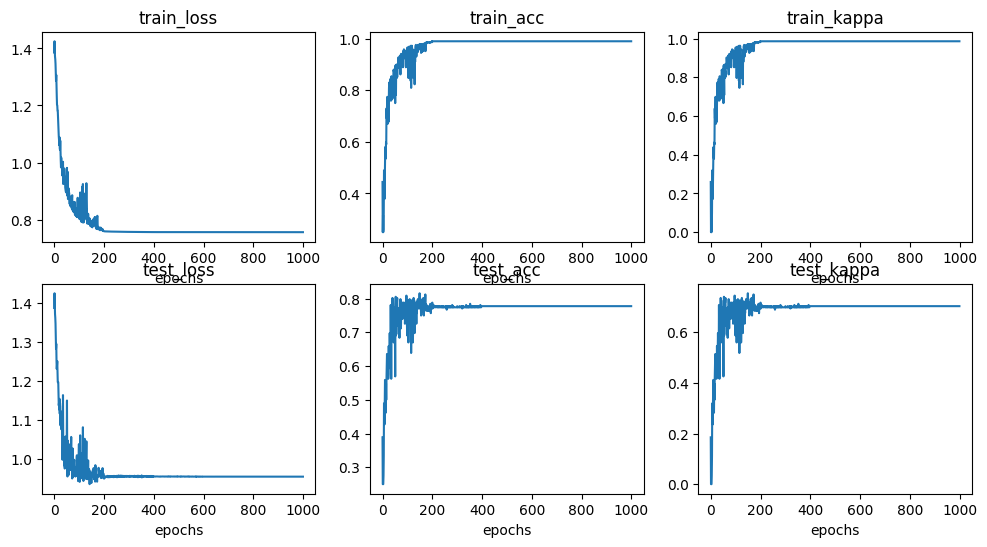

In [49]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6))

for i, title in enumerate(
    [
        "train_loss",
        "train_acc",
        "train_kappa",
        "test_loss",
        "test_acc",
        "test_kappa",
    ]
):
    axs[i // 3, i % 3].plot([i for i in range(len(history[title]))], history[title])
    axs[i // 3, i % 3].set_title(title)

for ax in axs.flat:
    ax.set(xlabel="epochs", ylabel="")

# Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in axs.flat:
#     ax.label_outer()